In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, TensorDataset

import tqdm

import tensorflow as tf
from tensorflow.keras import Sequential, layers, losses, optimizers, metrics

In [2]:
model_store = dict()

# Generate Data


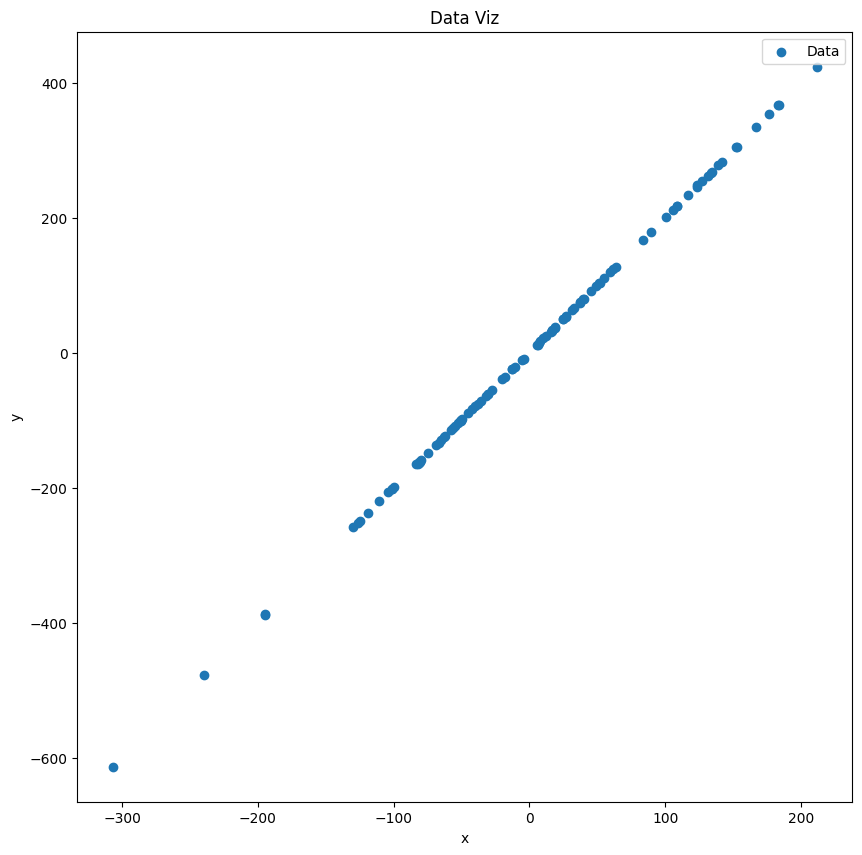

In [3]:
mean = 0
std = 100
n_points = 100
x = np.random.normal(mean, std, n_points)
a, b = 2, 1
y = a*x + b + np.random.normal(0, 0.5, n_points)

def data_viz(x, y, y_pred=[], labels=[], colors=[], title='Data Viz'):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111)


  ax.scatter(x, y, label='Data')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_title(title)

  for idx, yp in enumerate(y_pred):
    ax.plot(x, yp, color=colors[idx], label=labels[idx])
    ax.set_xlabel('x')
    ax.set_ylabel('y_pred')


  plt.legend()
  plt.show()

data_viz(x, y)

# Linear Regression (Pytorch)

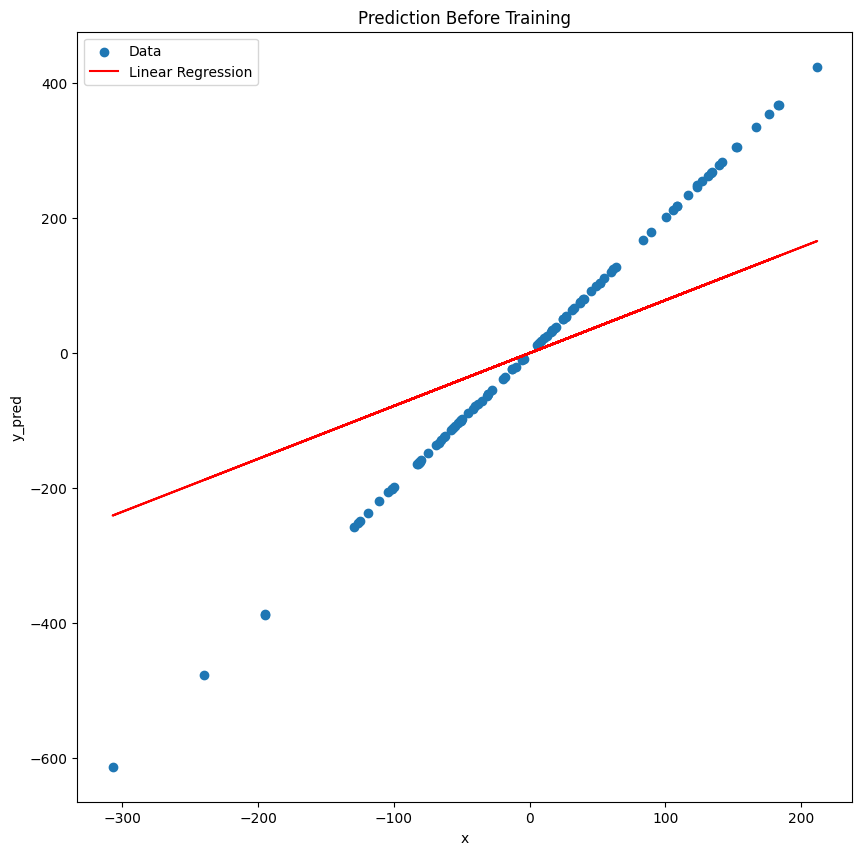

In [52]:
class LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.x = torch.tensor(x).to(torch.float32)
    self.a = nn.Parameter(torch.rand(1), requires_grad=True)
    self.b = nn.Parameter(torch.rand(1), requires_grad=True)

  def forward(self, x):
    return x*self.a + self.b

  def predict(self, x):
    with torch.no_grad():
      return self.forward(x)


model = LinearRegression()
x_tensor = torch.tensor(x).to(torch.float32)
y_tensor = torch.tensor(y).to(torch.float32)
output = model.predict(x_tensor)

data_viz(x, y, y_pred=[output.detach().numpy()], labels=['Linear Regression'], colors=['red'], title='Prediction Before Training')

Training Loop: 100%|██████████| 1500/1500 [00:15<00:00, 96.60it/s, loss=0.34] 


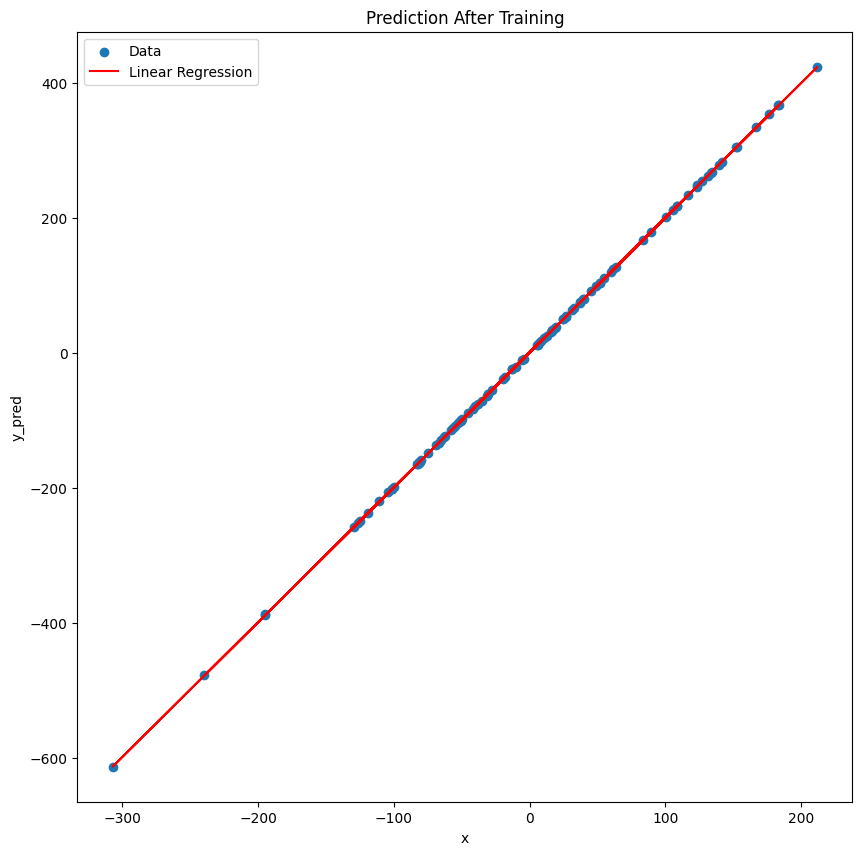

(array([1.9992851], dtype=float32), array([0.73781055], dtype=float32))

In [53]:
def train(model, dl, epochs, lr):
  model.train()
  optimizer = Adam(model.parameters(), lr=lr)

  with tqdm.tqdm(range(epochs), desc="Training Loop") as t:
    training_loss = list()
    for epoch in t:
      batch_loss = 0
      for x, y in dl:
        optimizer.zero_grad()
        output = model(x)
        loss = nn.functional.mse_loss(output, y)
        if loss.item() > 1e10:
          t.set_postfix(early_stopping="exploding gradients")
          return model
        loss.backward()
        batch_loss += loss.item()
        optimizer.step()
      training_loss.append(batch_loss/len(dl))
      t.set_postfix(loss=batch_loss/len(dl))

  return model, dict(loss=training_loss)

dataset = TensorDataset(x_tensor, y_tensor)
dl = DataLoader(dataset, batch_size=32, shuffle=True)
model, mh = train(model, dl, epochs=1500, lr=0.001)

model_store['Linear Regresion'] = model, mh

model.eval()
output = model.predict(x_tensor)

data_viz(x, y, y_pred=[output.detach().numpy()], labels=['Linear Regression'], colors=['red'], title='Prediction After Training')

model.a.detach().numpy(), model.b.detach().numpy()

# Neural Networks

In [9]:
def build_tensorflow_model(num_layers, input_dims, output_dims, hidden_dims=[]):
  """
  This function builds a tensorflow model with the given number of layers, input dimensions, output dimensions, and hidden dimensions.
  """
  model_layers = list()
  for nl in range(num_layers):
    if nl == 0:
      model_layers.append(layers.Dense(1, input_shape=(input_dims,), activation='linear'))
    elif nl == num_layers-1:
      model_layers.append(layers.Dense(output_dims, activation='linear'))
    else:
      model_layers.append(layers.Dense(hidden_dims.pop(0), activation='linear'))
  # Sequential groups a linear stack of Dense layers into a model
  model = Sequential(model_layers)
  # Prints model summary, layers, num of parameters
  model.summary()
  # Compiles the model by using a stochastic gradient descent and Mse for loss and accuracy calculation.
  model.compile(optimizer=optimizers.SGD(learning_rate=0.000001), loss=losses.MeanSquaredError(), metrics=[metrics.MeanSquaredError()])
  return model

def visualize_tfmodel(model_history, title='NN Training Loss'):
  """
  This function visualizes the training loss of a tensorflow model.
  """
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111)
  ax.plot(model_history.history['loss'], label='NN Training Loss')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.set_title(title)
  ax.legend()
  plt.show()

# 1 Hidden Layer

One Hidden layer works with a linear actions because y_pred = WX +b is the linear regression model which is also the output of our single dense layer network.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                     │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


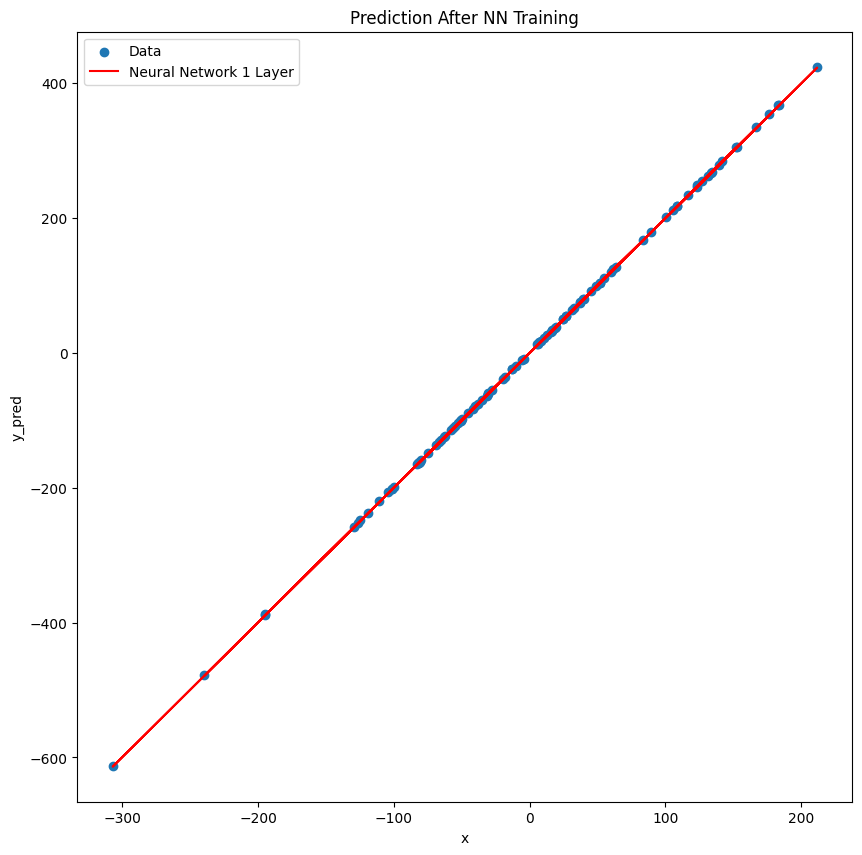

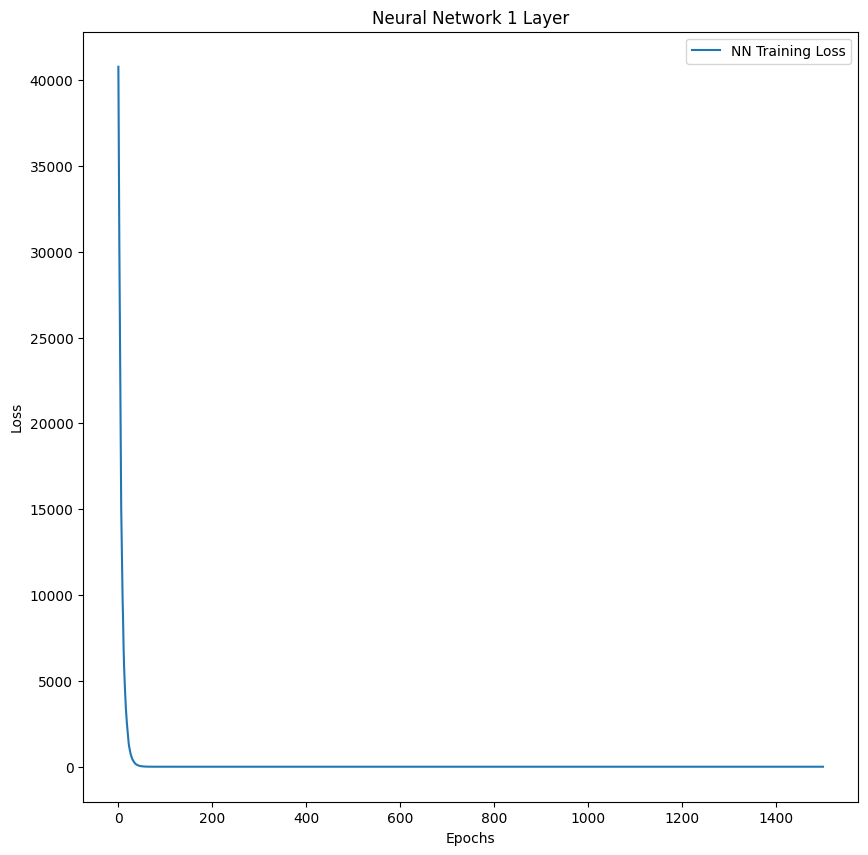

In [46]:
tf_model = build_tensorflow_model(num_layers=1, input_dims=1, output_dims=1)
mh = tf_model.fit(x, y, epochs=1500, batch_size=32, verbose=0)

key = 'Neural Network 1 Layer'
model_store[key] = (tf_model, mh)

y_pred_tf = tf_model.predict(x)
data_viz(x, y, y_pred=[y_pred_tf], labels=[key], colors=['red'],title='Prediction After NN Training')
visualize_tfmodel(mh, title=key)

# 2 Hidden Layer

2 Hidden layer works with linear activation functions because y_pred = W(WX +b)+b is the linear regression model which is also the output of our single dense layer network.

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                     │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4 (16.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


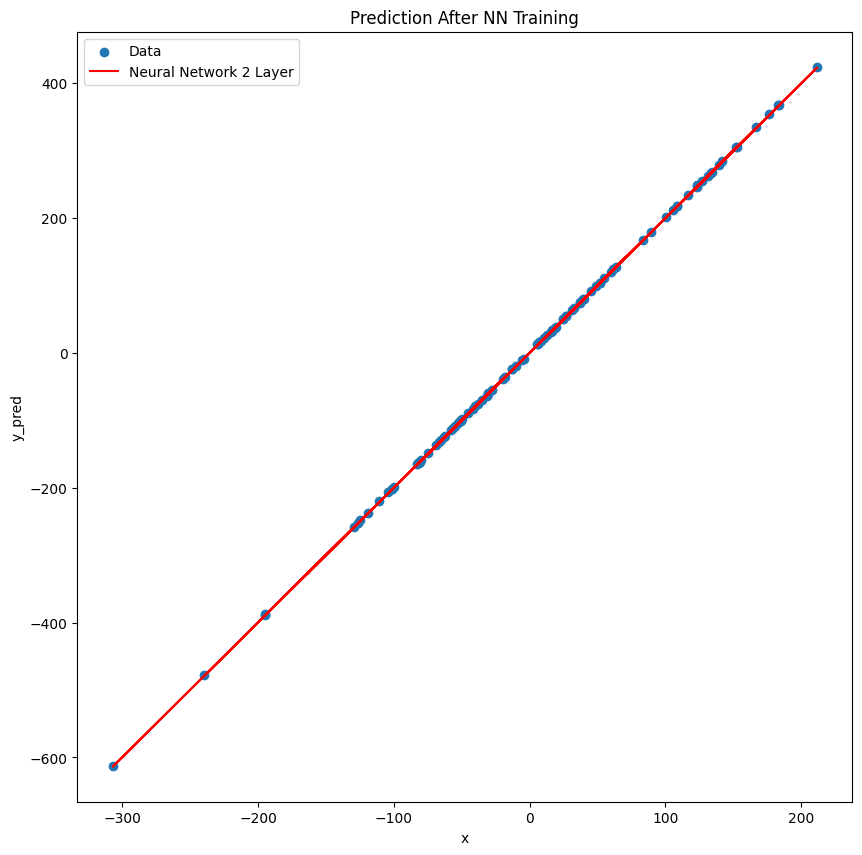

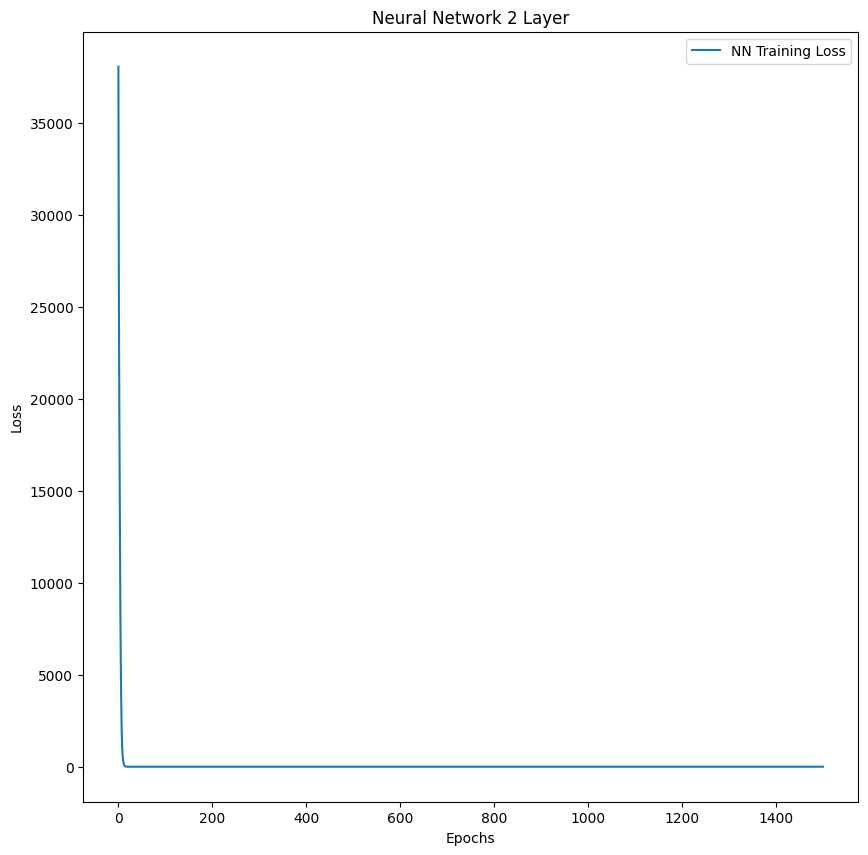

In [47]:
tf_model = build_tensorflow_model(num_layers=2, input_dims=1, output_dims=1, hidden_dims=[1])
mh = tf_model.fit(x, y, epochs=1500, batch_size=32, verbose=0)

key = 'Neural Network 2 Layer'
model_store[key] = (tf_model, mh)

y_pred_tf = tf_model.predict(x)
data_viz(x, y, y_pred=[y_pred_tf], labels=[key], colors=['red'],title='Prediction After NN Training')
visualize_tfmodel(mh, title=key)

# 3 Hidden Layer

3 Hidden layer works with linear activation functions because y_pred = W(W(WX +b)+b)+b is the linear regression model which is also the output of our single dense layer network.

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                     │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


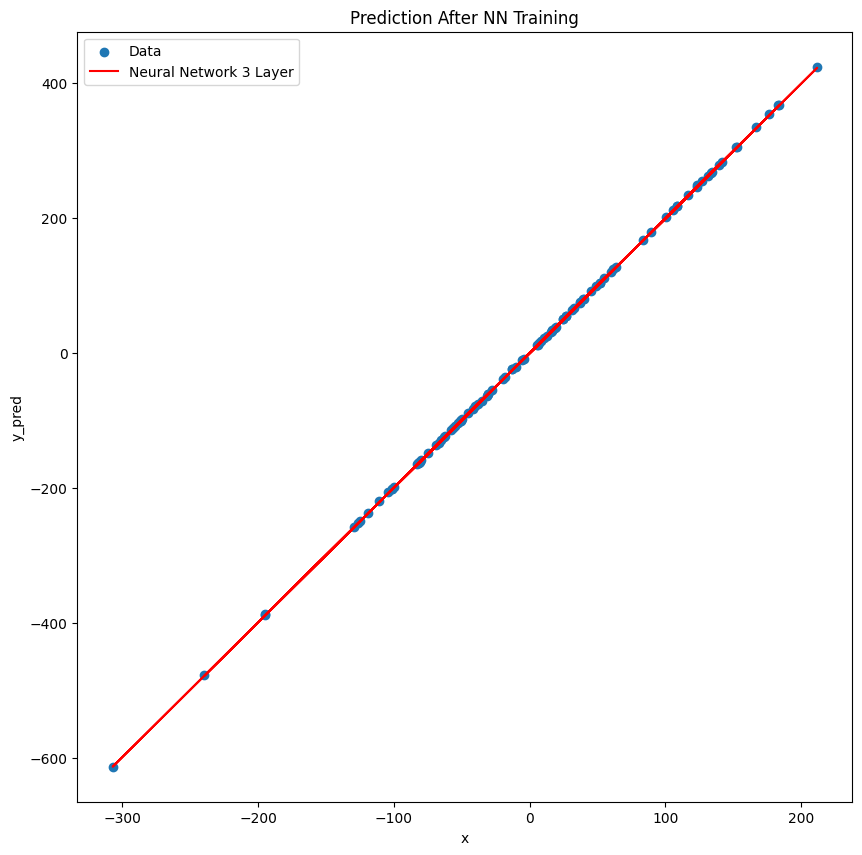

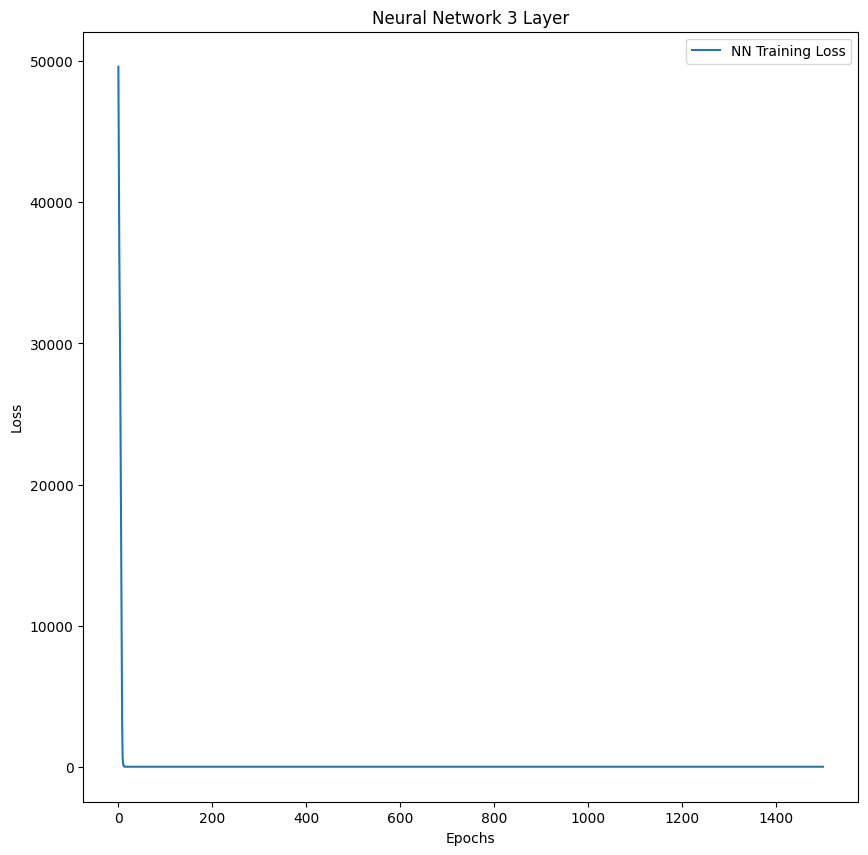

In [48]:
tf_model = build_tensorflow_model(num_layers=3, input_dims=1, output_dims=1, hidden_dims=[1])
mh = tf_model.fit(x, y, epochs=1500, batch_size=32, verbose=0)


key = 'Neural Network 3 Layer'
model_store[key] = (tf_model, mh)

y_pred_tf = tf_model.predict(x)
data_viz(x, y, y_pred=[y_pred_tf], labels=[key], colors=['red'],title='Prediction After NN Training')
visualize_tfmodel(mh, title=key)

# 4 Hidden Layer

4 Hidden layer works with linear activation functions because y_pred = W(W(W(WX +b)+b)+b)+b is the linear regression model which is also the output of our single dense layer network.

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                     │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8 (32.00 B)

 Trainable params: 8 (32.00 B)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


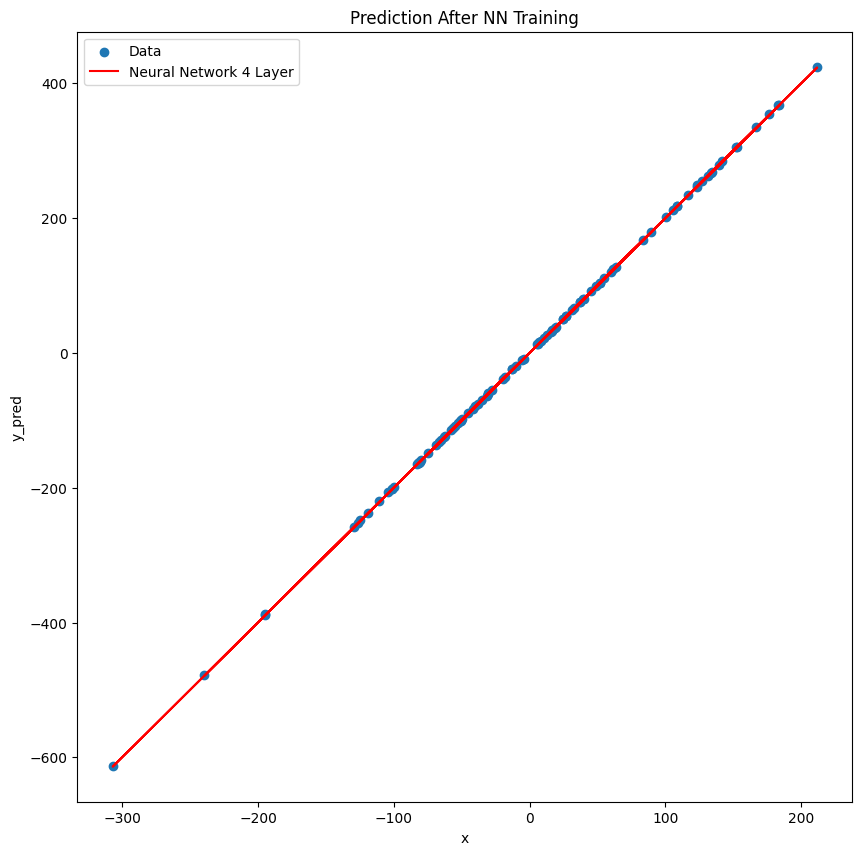

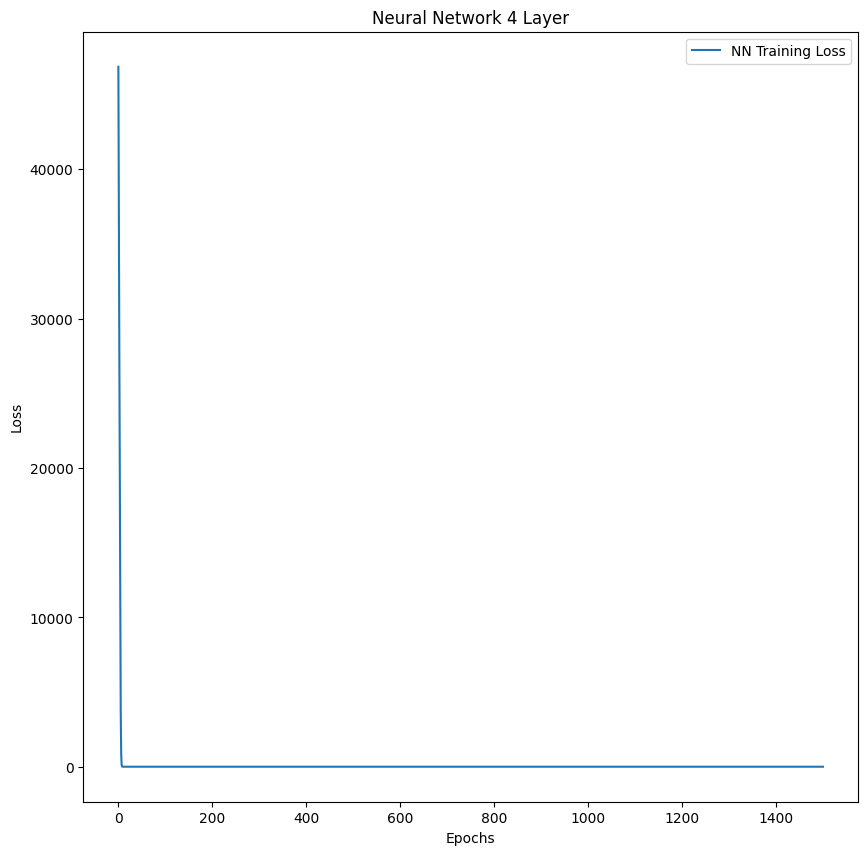

In [49]:
tf_model = build_tensorflow_model(num_layers=4, input_dims=1, output_dims=1, hidden_dims=[1, 1])
mh = tf_model.fit(x, y, epochs=1500, batch_size=32, verbose=0)

key = 'Neural Network 4 Layer'
model_store[key] = (tf_model, mh)

y_pred_tf = tf_model.predict(x)
data_viz(x, y, y_pred=[y_pred_tf], labels=[key], colors=['red'],title='Prediction After NN Training')
visualize_tfmodel(mh, title=key)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


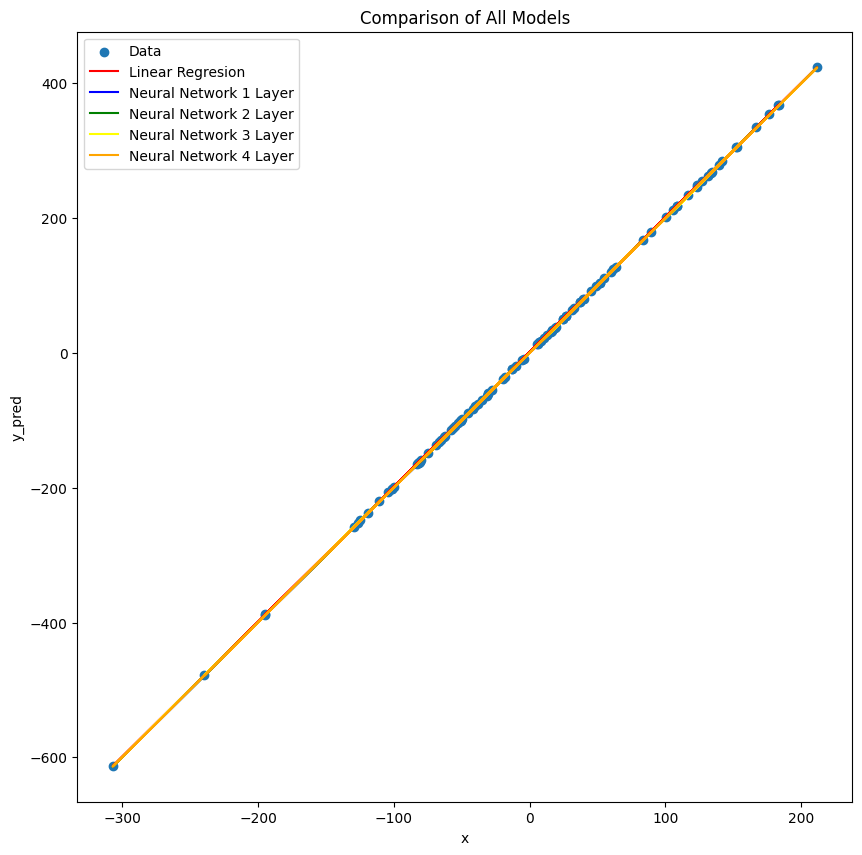

In [50]:
all_y_pred = list()
labels = list()
colors = ['red', 'blue', 'green', 'yellow', 'orange']
for key in sorted(model_store.keys()):
  model, _ = model_store[key]
  if type(model) == LinearRegression:
    all_y_pred.append(model.predict(x_tensor).detach().numpy())
  else:
    all_y_pred.append(model.predict(x))
  labels.append(key)

data_viz(x, y, y_pred=all_y_pred, labels=labels, colors=colors, title='Comparison of All Models')

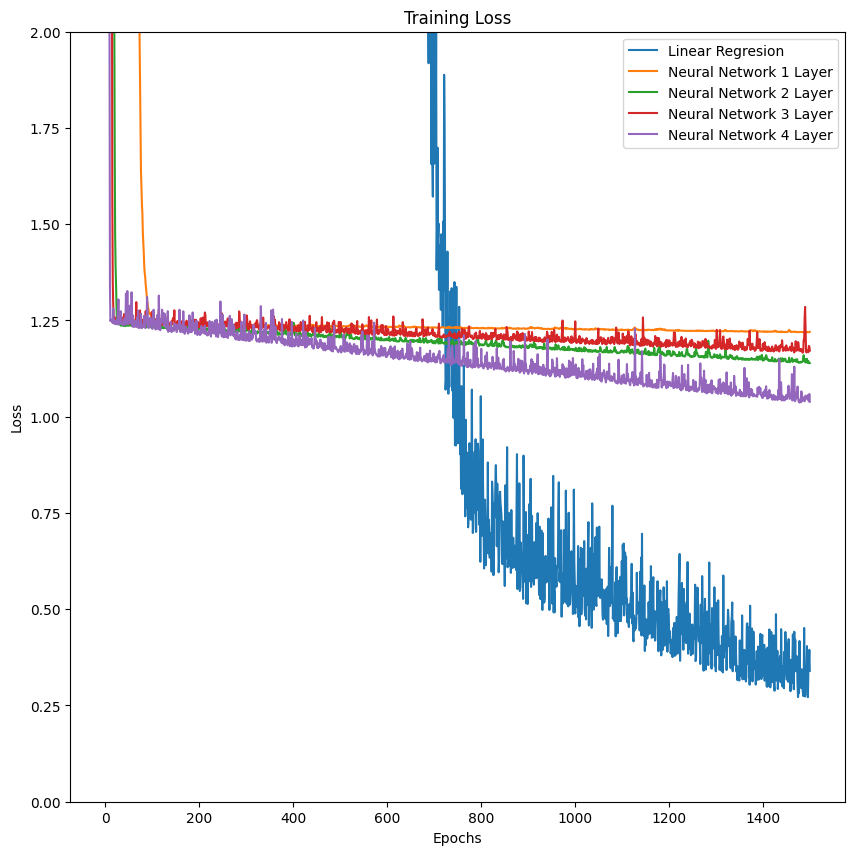

In [55]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for key in sorted(model_store.keys()):
  model, mh = model_store[key]
  if key != 'Linear Regresion':
    ax.plot(mh.history['loss'], label=key)
  else:
    plt.plot(mh['loss'], label=key)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.title('Training Loss')
plt.legend()

# Observations

Linear Regression has the lowest loss compared to all Neural Networks.

Neural Networks with less depth took more time to converge to a lower MSE loss. Neural Networks with greater depth also had a lower loss.

If we used a non-linear activation, our model would have fit our data to the loss function, (over-fitting).